# Main Code to Generate the dataset 

### Functions used

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

from PIL import Image
import numpy as np
import cv2
import time
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

In [11]:
def add_transparent_image(background, foreground, x_offset=None, y_offset=None):
    bg_h, bg_w, bg_channels = background.shape
    fg_h, fg_w, fg_channels = foreground.shape

    assert bg_channels == 3, f'background image should have exactly 3 channels (RGB). found:{bg_channels}'
    assert fg_channels == 4, f'foreground image should have exactly 4 channels (RGBA). found:{fg_channels}'

    # center by default
    if x_offset is None: x_offset = (bg_w - fg_w) // 2
    if y_offset is None: y_offset = (bg_h - fg_h) // 2

    w = min(fg_w, bg_w, fg_w + x_offset, bg_w - x_offset)
    h = min(fg_h, bg_h, fg_h + y_offset, bg_h - y_offset)

    if w < 1 or h < 1: return

    # clip foreground and background images to the overlapping regions
    bg_x = max(0, x_offset)
    bg_y = max(0, y_offset)
    fg_x = max(0, x_offset * -1)
    fg_y = max(0, y_offset * -1)
    foreground = foreground[fg_y:fg_y + h, fg_x:fg_x + w]
    background_subsection = background[bg_y:bg_y + h, bg_x:bg_x + w]

    # separate alpha and color channels from the foreground image
    foreground_colors = foreground[:, :, :3]
    alpha_channel = foreground[:, :, 3] / 255  # 0-255 => 0.0-1.0

    # construct an alpha_mask that matches the image shape
    alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

    # combine the background with the overlay image weighted by alpha
    composite = background_subsection * (1 - alpha_mask) + foreground_colors * alpha_mask

    # overwrite the section of the background image that has been updated
    background[bg_y:bg_y + h, bg_x:bg_x + w] = composite

In [7]:
def get_all_annotations_from_image(dataset, image_id):
    a = [a for a in dataset["annotations"] if a["image_id"] == image_id]
    return a

In [4]:
def on_top_of_text(bb, annotations): 
    # bb = [x, y, w, h]
    # it any of the corners of the bb is inside any of the annotations, return True
    x, y, w, h = bb
    for a in annotations:
        print("test", a["bbox"])
        x2, y2, w2, h2 = a["bbox"]
        if x2 <= x <= x2+w2 and y2 <= y <= y2+h2: return True
        if x2 <= x+w <= x2+w2 and y2 <= y <= y2+h2: return True
        if x2 <= x <= x2+w2 and y2 <= y+h <= y2+h2: return True
        if x2 <= x+w <= x2+w2 and y2 <= y+h <= y2+h2: return True
    return False

In [14]:
def create_COCO_annotation(dataset, image_id, category_id, x, y, w, h):
    # print(dataset)
    annotation = {
        "area": w * h,
        "iscrowd": 0,
        "image_id": image_id,
        "bbox": [x, y, w, h],
        "category_id": category_id, 
        "id": len(dataset["annotations"]) + 3265447 + 14423 + 1,
    }
    
    dataset["annotations"].append(annotation)
    return dataset

In [6]:
def add_stamps(n, page, stamps, stamps_ds, dataset, image_id, split="train"):
    label = 7
    
    img = page.copy()
    
    j = 0
    while j < n:
        idx = np.random.randint(0, len(stamps))
        if stamps[idx]['split'] != split:
            continue
        try: 
            stamp = cv2.imread(f"{stamps_ds}/preprocessed/{stamps[idx]['file_name']}", cv2.IMREAD_UNCHANGED)
            stamp = cv2.cvtColor(stamp, cv2.COLOR_BGR2RGBA)
            
            size = np.random.normal(200, 200)
            size = int(np.clip(size, 50, page.shape[1]*0.8))
            size = int(np.clip(size, 50, page.shape[0]*0.8))
            stamp = cv2.resize(stamp, (0,0), fx=size/stamp.shape[1], fy=size/stamp.shape[0])
            
            angle = np.random.randint(-30, 30)
            center = (stamp.shape[1]//2, stamp.shape[0]//2)
            M = cv2.getRotationMatrix2D(center, angle, 1)
            stamp = cv2.warpAffine(stamp, M, (stamp.shape[1], stamp.shape[0]))
            
            # print(f"stamp: {stamp.shape}, page: {page.shape}", page.shape[1]-stamp.shape[1], page.shape[0]-stamp.shape[0])
            
            # choose x_offset and y_offset while the stamp is on top of any annotation
            x_offset = np.random.randint(0, page.shape[1] - stamp.shape[1])
            y_offset = np.random.randint(0, page.shape[0] - stamp.shape[0])

            alpha = np.random.normal(1-(1/(page.shape[1]/size)), 0.2)
            # print(f"alpha: {0.8-(1/(page.shape[1]/size))}")
            alpha = np.clip(alpha, 0.1, 1)
            
            add_transparent_image(img, stamp*alpha, x_offset, y_offset)
            # cv2.rectangle(img, (x_offset, y_offset), (x_offset+stamp.shape[1], y_offset+stamp.shape[0]), (0, 255, 0), 4)
            
            dataset = create_COCO_annotation(dataset, image_id, label, x_offset, y_offset, stamp.shape[1], stamp.shape[0])
        
            j += 1
        except:
            print(f"Error adding stamp {stamps[idx]['file_name']}")
            raise(Exception)
        
    return img, dataset

In [7]:
def add_qrs(n, page, qrs, qrs_dataset, dataset, image_id, split='train'):
    label = 8
    img = page.copy()
        
    j = 0
    while j < n:
        idx = np.random.randint(0, len(qrs))
        if qrs[idx]['split'] != split:
            continue
        try: 
            
            # print(f"Adding QR code {qrs_dataset}/preprocessed/{qrs[idx]['file_name']}")
            
            qr = cv2.imread(f"{qrs_dataset}/preprocessed/{qrs[idx]['file_name']}", cv2.IMREAD_UNCHANGED)
            # crop a 5 % of the image per each side
            qr = qr[qr.shape[0]//10:qr.shape[0]-(qr.shape[0]//10), qr.shape[1]//10:qr.shape[1]-(qr.shape[1]//10)]


            size = np.random.randint(50, 175)
            qr = cv2.resize(qr, (0,0), fx=size/qr.shape[1], fy=size/qr.shape[0])
            
            x_offset = np.random.randint(0, page.shape[1] - qr.shape[1])
            y_offset = np.random.randint(0, page.shape[0] - qr.shape[0])

            alpha = np.random.normal(0.9, 0.2)
            alpha = np.clip(alpha, 0.1, 0.85)
            
            add_transparent_image(img, qr*alpha, x_offset, y_offset)
            #cv2.rectangle(img, (x_offset, y_offset), (x_offset+qr.shape[1], y_offset+qr.shape[0]), (0, 0, 255), 3)
            
            dataset = create_COCO_annotation(dataset, image_id, label, x_offset, y_offset, qr.shape[1], qr.shape[0])
        
            j += 1
        except:
            print(f"Error adding qr {qrs[idx]['file_name']}")
            raise(Exception)
            
    return img, dataset

In [8]:
def add_barcodes(n, page, barcodes, barcodes_dataset, dataset, image_id, split='train'):
    label = 9
    img = page.copy()
        
    j = 0
    while j < n:
        idx = np.random.randint(0, len(barcodes))
        if barcodes[idx]['split'] != split:
            continue
        try: 
            
            # print(f"Adding QR code {qrs_dataset}/preprocessed/{qrs[j]['file_name']}")
            
            barcode = cv2.imread(f"{barcodes_dataset}/preprocessed/{barcodes[idx]['file_name']}", cv2.IMREAD_UNCHANGED)
            # crop a 5 % of the image per each side
            # barcode = barcode[qr.shape[0]//10:qr.shape[0]-(qr.shape[0]//10), qr.shape[1]//10:barcode.shape[1]-(barcode.shape[1]//10)]


            size = np.random.randint(50, 175)
            barcode = cv2.resize(barcode, (0,0), fx=size/barcode.shape[1], fy=size/barcode.shape[0])
            
            x_offset = np.random.randint(0, page.shape[1] - barcode.shape[1])
            y_offset = np.random.randint(0, page.shape[0] - barcode.shape[0])

            alpha = np.random.normal(0.9, 0.2)
            alpha = np.clip(alpha, 0.1, 1)
            
            add_transparent_image(img, barcode*alpha, x_offset, y_offset)
            # cv2.rectangle(img, (x_offset, y_offset), (x_offset+barcode.shape[1], y_offset+barcode.shape[0]), (0, 255, 255), 3)
            
            dataset = create_COCO_annotation(dataset, image_id, label, x_offset, y_offset, barcode.shape[1], barcode.shape[0])
            
            j += 1
        except:
            print(f"Error adding barcode {barcodes[idx]['file_name']}")
            raise(Exception)
            
    return img, dataset

In [9]:
def add_border(dir_borders, img):
    try:
        img = Image.fromarray(img)
    except: 
        pass
    
    border = random.choice(os.listdir(dir_borders))
    border = Image.open(f"{dir_borders}/{border}")
    print(border.size, img.size)
    border = border.resize(img.size)
    img.paste(border, (0, 0), border)
    return img

In [10]:
def add_bkg_noise(img):
    orig = img.copy()
    bkg = np.zeros_like(img)
    
    # choose a random num between 3 and 25
    num_letters = random.randint(5, 25)
    
    #choose a random combination of letters and numbers with the length of num_letters
    letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789              '
    bkg_text = ''.join(random.choices(letters, k=num_letters))
    
    alpha = random.randint(0, 50)
    font_size = random.randint(15, 30)
    
    img = Image.fromarray(img)
    
    bkg_text = bkg_text * (img.size[0] * 5 // (len(bkg_text)*font_size) + 1)

    # create a new image with the bkg_text
    bkg_img = Image.new('RGB', img.size, (0, 0, 0))
    for j in range(0, img.size[1], int(font_size*1.1)):
        i = random.randint(-200, 0)
        draw = ImageDraw.Draw(bkg_img)
        draw.text((i, j), bkg_text, fill=(alpha, alpha, alpha), font_size=font_size)
    
    solid_color = Image.new('RGB', img.size, (0, 0, 0))
    bkg_img = bkg_img.convert('L')
    solid_color.putalpha(bkg_img)
    img.paste(solid_color, (0, 0), solid_color)
    return img

In [11]:
def generate_gradient_mask(shape, direction='vertical', direction_type='dark_to_light'):
    height, width = shape
    gradient_mask = np.zeros(shape, dtype=np.float32)
    
    maxx = random.uniform(1.1, 1.5)
    minn = random.uniform(0.5, 0.8)
    
    if direction == 'vertical':
        for y in range(height):
            alpha = y / height if direction_type == 'dark_to_light' else 1 - y / height
            alpha = alpha * (maxx - minn) + minn
            gradient_mask[y, :] = alpha
    elif direction == 'horizontal':
        for x in range(width):
            alpha = x / width if direction_type == 'dark_to_light' else 1 - x / width
            alpha = alpha * (maxx - minn) + minn
            gradient_mask[:, x] = alpha
    elif direction == 'diagonal':
        for y in range(height):
            for x in range(width):
                alpha = min(y, x) / max(height, width) if direction_type == 'dark_to_light' else 1 - min(y, x) / max(height, width)
                alpha = alpha * (maxx - minn) + minn
                gradient_mask[y, x] = alpha
    else:
        gradient_mask = np.ones(shape, dtype=np.uint8)
    return gradient_mask

def add_lighting_and_yellow_tint(img):
    img_array = np.array(img)
    # Randomly adjust the yellowish tint
    yellow_factor = random.uniform(0.6, 1)  # Random factor between 0.5 and 1.0
    
    corr_green = random.uniform(0.7, 1)
    corr_red = random.uniform(1, 1.2)
    
    yellow_factor_red = np.clip(yellow_factor*corr_red, 0, 1)
    
    
    img_array[:, :, 0] = img_array[:, :, 0] * yellow_factor_red  # Increasing red channel
    img_array[:, :, 1] = img_array[:, :, 1] * yellow_factor  # Reducing green channel
    img_array[:, :, 2] = img_array[:, :, 2] * yellow_factor * corr_green  # Reducing blue channel

    # Convert array back to image
    yellow_tint_img = Image.fromarray(img_array)

    # Generate a random direction for the lighting overlay
    directions = ['vertical', 'horizontal', 'diagonal', 'none']
    direction = random.choice(directions)
    
    # Generate a random direction type (dark_to_light or light_to_dark) if the direction is horizontal or vertical
    direction_type = 'dark_to_light' if random.choice([True, False]) else 'light_to_dark'

    # Generate gradient mask with random direction and type
    gradient_mask = generate_gradient_mask(img_array.shape[:2], direction, direction_type)
    lighting_factor = random.uniform(0.2, 0.5)  # Random factor between 0.2 and 0.5
    img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    
    # transform the uint8 image to float32
    img_array = img_array.astype(np.float32)
    img_array[:, :, 0] = img_array[:, :, 0] * gradient_mask
    img_array[:, :, 0] = np.clip(img_array[:, :, 0], 0, 254)
    print(img_array[:, :, 0].shape, img_array[:, :, 0].min(), img_array[:, :, 0].max())
    
    # transform the float32 image to uint8
    img_array = img_array.astype(np.uint8)
    
    # Convert lab to rgb
    img_array = cv2.cvtColor(img_array, cv2.COLOR_LAB2RGB)
    
    # Convert array back to image
    overlayed_img = Image.fromarray(img_array)

    return overlayed_img

In [17]:
def add_signatures(n, list_of_imgs, signatures, signatures_ds, dataset, image_id, split='train'):
    label = 6
    
    j = 0
    while j < n:
        idx = np.random.randint(0, len(signatures))
        if signatures[idx]['split'] != split:
            continue
        try: 
            #signature = cv2.imread(f"{signatures_ds}/dataset3/forge_preprocessed/{signatures[idx]['file_name']}", cv2.IMREAD_UNCHANGED)
            signature = cv2.imread(f"{signatures_ds}/preprocessed/{signatures[idx]['file_name']}", cv2.IMREAD_UNCHANGED)
            signature = cv2.cvtColor(signature, cv2.COLOR_BGR2RGBA)
            #print(signature)
            
            size = np.random.randint(50, 200)
            signature = cv2.resize(signature, (0,0), fx=size/signature.shape[1], fy=size/signature.shape[0])
            
            # rotate the image randomly
            angle = np.random.randint(-30, 30)
            center = (signature.shape[1]//2, signature.shape[0]//2)
            M = cv2.getRotationMatrix2D(center, angle, 1)
            signature = cv2.warpAffine(signature, M, (signature.shape[1], signature.shape[0]))
            
            
            x_offset = np.random.randint(0, list_of_imgs[0].shape[1] - signature.shape[1])
            y_offset = np.random.randint(0, list_of_imgs[0].shape[0] - signature.shape[0])

            alpha = np.random.normal(0.9, 0.2)
            alpha = 1
            
            for img in list_of_imgs:
                add_transparent_image(img, signature*alpha, x_offset, y_offset)
            # cv2.rectangle(img, (x_offset, y_offset), (x_offset+signature.shape[1], y_offset+signature.shape[0]), (255, 0, 255), 3)
            
            dataset = create_COCO_annotation(dataset, image_id, label, x_offset, y_offset, signature.shape[1], signature.shape[0])
            
            j += 1
            
        except:
            print(f"Error adding signature {signatures[idx]['file_name']}")
            raise(Exception)
            
    return list_of_imgs, dataset

#### adding stamps and signatures only over the text region

### Code

In [1]:
split = "val"

In [2]:
import json

dir2publaynet = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Publaynet"

dir2signatures = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Signatures_dataset"
dataset = "preprocessed"

dir2stamps = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Stamps_dataset"
dir2qrs = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/QRs_dataset/"
dir2barcodes = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Barcodes_dataset"
dir_borders = r"C:\Users\Maria\OneDrive - UAB\Documentos\3r de IA\Synthesis project II\Github\Project_Synthesis2-\Datasets\Borders"



dir2publaynet = "/hhome/ps2g07/document_analysis/github/Project_Synthesis2-/Datasets/Publaynet"

dir2signatures = "/hhome/ps2g07/document_analysis/github/Project_Synthesis2-/Datasets/Signatures_dataset"
dataset = "preprocessed"

dir2stamps = "/hhome/ps2g07/document_analysis/github/Project_Synthesis2-/Datasets/Stamps_dataset"
dir2qrs = "/hhome/ps2g07/document_analysis/github/Project_Synthesis2-/Datasets/QRs_dataset/"
dir2barcodes = "/hhome/ps2g07/document_analysis/github/Project_Synthesis2-/Datasets/Barcodes_dataset"
dir_borders = "/hhome/ps2g07/document_analysis/github/Project_Synthesis2-/Datasets/Borders"



with open(f"{dir2publaynet}/{split}_syn.json", 'r') as f:
   publaynet = json.load(f)   

"""with open(f"{dir2publaynet}/{split}.json", 'r') as f:
     publaynet = json.load(f)"""

with open(f"{dir2stamps}/splits.json", 'r') as f:
    stamps = json.load(f)
    
with open(f"{dir2signatures}/splits.json", 'r') as f:
    signatures = json.load(f) 

with open(f"{dir2qrs}/splits.json", 'r') as f:
    qrs = json.load(f)

with open(f"{dir2barcodes}/splits.json", 'r') as f:
    barcodes = json.load(f)

In [3]:
import os

#ds_dir = '/hhome/ps2g07/document_analysis/github/Project_Synthesis2-/Datasets/Publaynet/Publaynet_partition_1/Synthetics_DS_partition1'
# ds_dir = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS_v2"
ds_dir = "/hhome/ps2g07/document_analysis/github/Project_Synthesis2-/Datasets/Synthetic_DS_v2"
os.makedirs(ds_dir, exist_ok=True)

In [4]:
dataset = {"categories":publaynet["categories"].copy(),
            "images":[],
            "annotations":[]}

dataset["categories"].append({'supercategory': '', 'id': 6, 'name': 'signature'})
dataset["categories"].append({'supercategory': '', 'id': 7, 'name': 'stamp'})
dataset["categories"].append({'supercategory': '', 'id': 8, 'name': 'qr'})
dataset["categories"].append({'supercategory': '', 'id': 9, 'name': 'barcode'})
# dataset["categories"]

0it [00:00, ?it/s]

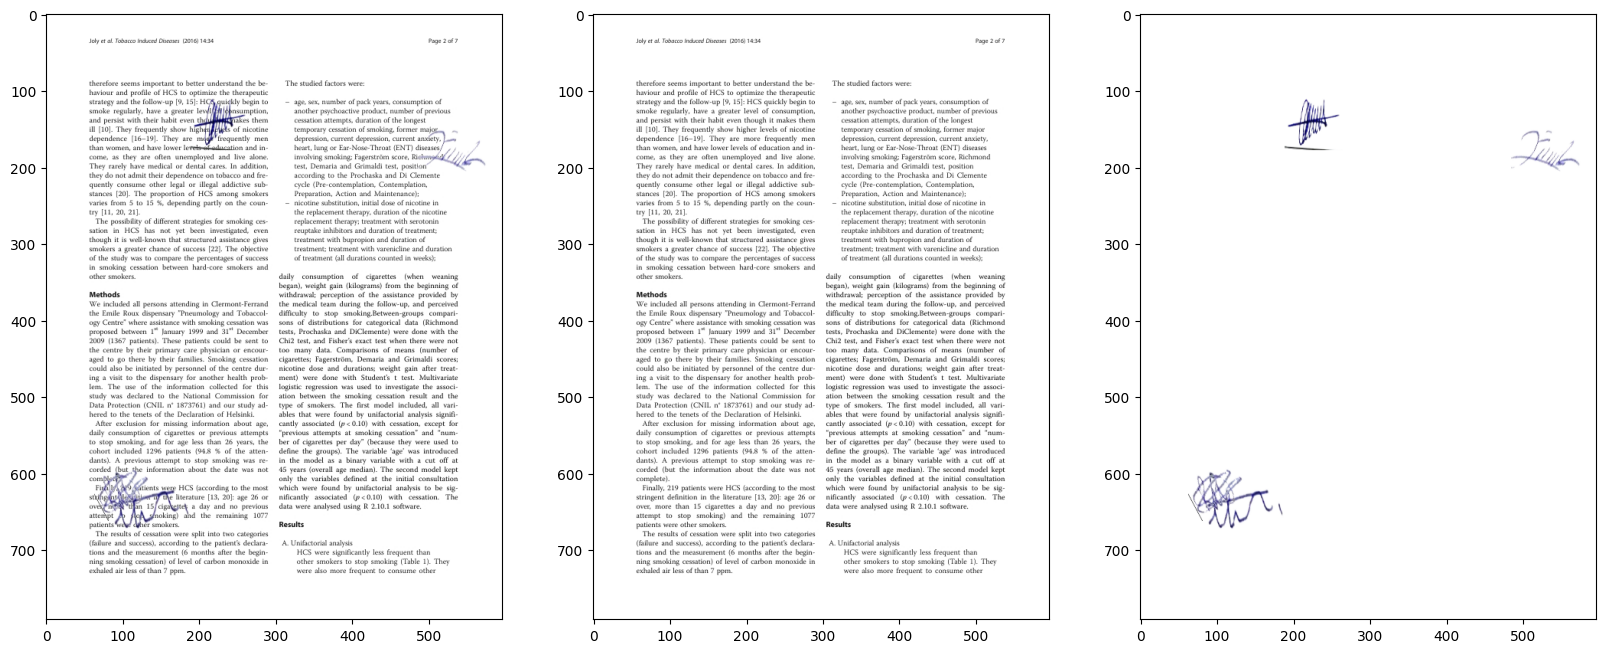

0it [00:00, ?it/s]


In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

for i, sample in tqdm(enumerate(publaynet["images"])):     
    dataset["annotations"].append(get_all_annotations_from_image(publaynet, int(sample["id"])))
    
    l0 = cv2.imread(f"{dir2publaynet}/train/{sample['file_name']}")
    l0 = cv2.cvtColor(l0, cv2.COLOR_BGR2RGB)
    
    all = l0.copy()
    l1 = np.ones_like(l0) * 255
    
    # n = np.random.randint(1, 4)
    # imgs, dataset = add_stamps(n, [all, l1], stamps, dir2stamps, dataset, sample['id'])
    # all, l1 = imgs

    n = np.random.randint(0, 5)
    imgs, dataset = add_signatures(n, [all, l1], signatures, dir2signatures, dataset, sample['id'])
    all, l1 = imgs
    
    # n = np.random.randint(0, 3)
    # imgs, dataset = add_qrs(n, [all, l1], qrs, dir2qrs, dataset, sample['id'])
    # all, l1 = imgs
    
    # n = np.random.randint(0, 2)
    # imgs, dataset = add_barcodes(n, [all, l1], barcodes, dir2barcodes, dataset, sample['id'])
    # all, l1 = imgs
    
    # if random.choice([True, False]):
    #     imgs = add_bkg_noise([all, l1])
    #     all, l1 = imgs
    
    # if random.choice([True, False, False, False, False, False]):
    #     imgs = add_border(dir_borders, [all, l0, l1])
    #     all, l0, l1 = imgs
        
    # img = add_lighting_and_yellow_tint([all, l1])
    # all, l1 = img
    
    # Save the image
    # os.makedirs(f"{ds_dir}/{split}", exist_ok=True)

    # show the 3 images
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(all)
    ax[1].imshow(l0)
    ax[2].imshow(l1)
    plt.show()
    break
    
    cv2.imwrite(f"{ds_dir}/{split}/{sample['file_name']}", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    # print(f"Image {sample['file_name']} saved")
    
    if i % 100 == 0:
        with open(f"{ds_dir}/{split}.json", 'w') as f:
            json.dump(dataset, f)
        print(f"Dataset saved at {ds_dir}/{split}.json") 

In [35]:
dataset["images"] = publaynet["images"]

#remove all [] from the annotations list
dataset["annotations"] = [item for item in dataset["annotations"] if item != []]

with open(f"{ds_dir}/{split}.json", 'w') as f:
    json.dump(dataset, f)